In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
import tensorflow as tf
import utils.data
from utils.layers import Encoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mfcc')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0, dtype=np.float32)

In [6]:
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [7]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [8]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1]),return_sequences=True))),
lstm_model.add(Bidirectional(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))),
#lstm_model.add(LSTM(64, input_shape=(X_train.shape[-2], X_train.shape[-1]),return_sequences=True))
#lstm_model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1])))
lstm_model.add(Dense(4*len(data["mapping"]), activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(len(data["mapping"]), activation='softmax'))

In [9]:
lstm_model.build(input_shape=(X_train.shape))

In [10]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (6989, 130, 256)         145408    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (6989, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (6989, 40)                10280     
                                                                 
 dropout (Dropout)           (6989, 40)                0         
                                                                 
 dense_1 (Dense)             (6989, 10)                410       
                                                                 
Total params: 550,338
Trainable params: 550,338
Non-trai

In [11]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [13]:
lstm_history = lstm_model.fit(X_train, Y_train,
              batch_size=32,
              epochs=40,
              validation_data=(X_valid, Y_valid),
              verbose=1, 
              callbacks=es)

Epoch 1/40
219/219 [==============================] - 14s 35ms/step - loss: 1.4524 - accuracy: 0.4876 - val_loss: 1.8257 - val_accuracy: 0.3771
Epoch 2/40
219/219 [==============================] - 6s 29ms/step - loss: 1.1451 - accuracy: 0.6034 - val_loss: 1.8709 - val_accuracy: 0.3581
Epoch 3/40
219/219 [==============================] - 6s 29ms/step - loss: 0.9931 - accuracy: 0.6573 - val_loss: 1.7984 - val_accuracy: 0.4107
Epoch 4/40
219/219 [==============================] - 6s 28ms/step - loss: 0.9503 - accuracy: 0.6663 - val_loss: 1.8346 - val_accuracy: 0.3972
Epoch 5/40
219/219 [==============================] - 6s 28ms/step - loss: 0.8726 - accuracy: 0.6992 - val_loss: 2.0673 - val_accuracy: 0.3927
Epoch 6/40
219/219 [==============================] - 6s 28ms/step - loss: 0.7816 - accuracy: 0.7300 - val_loss: 2.0533 - val_accuracy: 0.4012
Epoch 7/40
219/219 [==============================] - 6s 28ms/step - loss: 0.7031 - accuracy: 0.7505 - val_loss: 1.9708 - val_accuracy: 0.421

32/32 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.15      0.11      0.13       100
           1       0.88      0.74      0.80        99
           2       0.20      0.32      0.25        99
           3       0.51      0.42      0.46        99
           4       0.16      0.15      0.16        99
           5       0.45      0.40      0.43        99
           6       0.49      0.71      0.58       100
           7       0.91      0.89      0.90       100
           8       0.36      0.19      0.25       100
           9       0.37      0.45      0.41       100

    accuracy                           0.44       995
   macro avg       0.45      0.44      0.44       995
weighted avg       0.45      0.44      0.44       995



<Axes: >

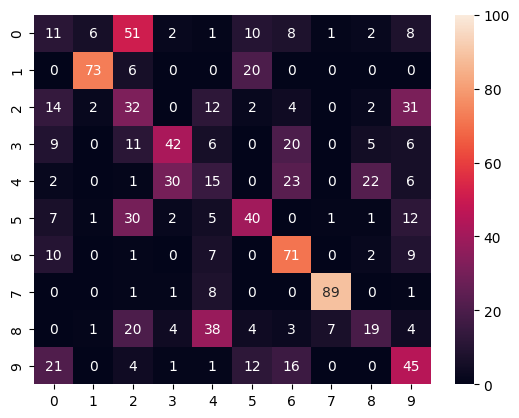

In [14]:
lstm_preds = lstm_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(lstm_preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(lstm_preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [15]:
lstm_model.save("models/lstm.h5")